## Assignment:

Beat the performance of my Lasso regression by **using different feature engineering steps ONLY!!**.

The performance of my current model, as shown in this notebook is:

- test mse: 1063016789.3316755
- test rmse: 32603.938248801718
- test r2: 0.8453144708738004

To beat my model you will need a test r2 bigger than 0.85 and a rmse smaller than 32603.


=====================================================================================================


### Conditions:

- You MUST NOT change the hyperparameters of the Lasso.
- You MUST use the same seeds in Lasso and train_test_split as I show in this notebook (random_state)
- You MUST use all the features of the dataset (except Id) - you MUST NOT select features


=====================================================================================================


### If you beat my model:

Make a pull request with your notebook to this github repo:
https://github.com/solegalli/udemy-feml-challenge

And add your notebook to the folder:

-StudentsSolutions_v1.0.0

### How to make the PR

1) fork the repo:

Go to https://github.com/solegalli/udemy-feml-challenge, and click on the **fork** button at the top-right

2) clone your forked repo into your local computer:

- Go to www.github.com/yourusername/udemy-feml-challenge
- Click the green button that says clone or download
- copy the url that opens up
- power up a git console
- type: git clone (paste the url you copied from github)
- done

3) Make a copy of the jupyter notebook and add your name:

- Open up the Jupyter notebook called 13-Assignement.ipynb
- Click the "File" button at the top-right and then click "Make a copy"
- **Work your solution in the Copy** and not in the original assignment (otherwise there will be conflicts when making the PR)
- Change the name of the copy of the notebook to: 13-Assignement_yourname.ipynb
- Move the notebook to the folder **StudentsSolutions_v1.0.0**
- done

When you finish, just commit the new notebook to your fork and then make a PR to my repo.

- git add StudentsSolutions_v1.0.0/13-Assignement_yourname.ipynb
- git commit -m "your commit message"
- git push origin master or git push origin yourfeaturebranch
- go to your repo and make a pull request.


## But i have a notebook ready and I haven't cloned the repo yet, how can I make the PR?

If you worked in the copy you downloaded from Udemy before forking and cloning this repo, then follow this steps:

1) fork the repo:

Go to https://github.com/solegalli/udemy-feml-challenge, and click on the fork button at the top-right

2) clone your forked repo into your local computer:

Go to www.github.com/yourusername/udemy-feml-challenge

- Click the green button that says clone or download
- Copy the url that opens up
- Power up a git console
- Type: git clone (paste the url you copied from github)
- Done

3) Rename your solution as follows and copy it into your cloned repo:

- Rename your solution notebook to: 13-Assignement_yourname.ipynb
- Copy this file into the cloned repo, inside the folder **StudentsSolutions_v1.0.0**
- Done

When you finish, just commit the new notebook to your fork and then make a PR to my repo

- git add StudentsSolutions_v1.0.0/13-Assignement_yourname.ipynb
- git commit -m "your commit message"
- git push origin master or git push origin yourfeaturebranch
- go to your repo and make a pull request.

**Good luck!!**

## House Prices dataset

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# for feature engineering
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

In [9]:
pd.set_option('display.max_columns', None)

### Load Datasets

In [2]:
# load dataset

data = pd.read_csv('../houseprice.csv')

In [3]:
# make lists of variable types

categorical = [var for var in data.columns if data[var].dtype == 'O']

year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]

discrete = [
    var for var in data.columns if data[var].dtype != 'O'
    and len(data[var].unique()) < 20 and var not in year_vars
]

numerical = [
    var for var in data.columns if data[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice']
    and var not in year_vars
]

print('There are {} continuous variables'.format(len(numerical)))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} temporal variables'.format(len(year_vars)))
print('There are {} categorical variables'.format(len(categorical)))

There are 18 continuous variables
There are 14 discrete variables
There are 4 temporal variables
There are 43 categorical variables


### Separate train and test set

In [4]:
# IMPORTANT: keep the random_state to zero for reproducibility
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(
    ['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.1,
    random_state=0)

In [5]:
# calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [6]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [7]:
# capture the column names for use later in the notebook
final_columns = X_train.columns

In [10]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition
930,20,RL,73.0,8925,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,8,5,2,2,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,16,Unf,0,1450,1466,GasA,Ex,Y,SBrkr,1466,0,0,1466,0,0,2,0,3,1,Gd,7,Typ,0,NaN,Attchd,2.0,Fin,3,610,TA,TA,Y,100,18,0,0,0,0,NaN,NaN,NaN,0,7,WD,Normal
656,20,RL,72.0,10007,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,49,2,Gable,CompShg,HdBoard,HdBoard,BrkFace,54.0,Gd,TA,CBlock,TA,TA,No,ALQ,806,Unf,0,247,1053,GasA,Ex,Y,SBrkr,1053,0,0,1053,1,0,1,1,3,1,Gd,5,Typ,0,NaN,Attchd,49.0,RFn,1,312,TA,TA,Y,0,0,0,0,0,0,NaN,MnPrv,NaN,0,8,WD,Normal
45,120,RL,61.0,7658,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,TwnhsE,1Story,9,5,5,5,Hip,CompShg,MetalSd,MetalSd,BrkFace,412.0,Ex,TA,PConc,Ex,TA,No,GLQ,456,Unf,0,1296,1752,GasA,Ex,Y,SBrkr,1752,0,0,1752,1,0,2,0,2,1,Ex,6,Typ,1,Gd,Attchd,5.0,RFn,2,576,TA,TA,Y,196,82,0,0,0,0,NaN,NaN,NaN,0,2,WD,Normal
1348,20,RL,NaN,16196,Pave,NaN,IR3,Low,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,7,5,9,9,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,Gd,GLQ,1443,Unf,0,39,1482,GasA,Ex,Y,SBrkr,1494,0,0,1494,1,0,2,0,3,1,Gd,5,Typ,1,Fa,Attchd,9.0,RFn,2,514,TA,TA,Y,402,25,0,0,0,0,NaN,NaN,NaN,0,8,WD,Normal
55,20,RL,100.0,10175,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,44,44,Gable,CompShg,HdBoard,Plywood,BrkFace,272.0,TA,TA,CBlock,TA,TA,No,BLQ,490,Unf,0,935,1425,GasA,Gd,Y,SBrkr,1425,0,0,1425,0,0,2,0,3,1,TA,7,Typ,1,Gd,Attchd,44.0,RFn,2,576,TA,TA,Y,0,0,0,407,0,0,NaN,NaN,NaN,0,7,WD,Normal


In [11]:
categorical = [var for var in X_train.columns if X_train[var].dtype == 'O']

year_vars = [var for var in X_train.columns if 'Yr' in var or 'Year' in var]

discrete = [
    var for var in X_train.columns if X_train[var].dtype != 'O'
    and len(X_train[var].unique()) < 20 and var not in year_vars
]

numerical = [
    var for var in X_train.columns if X_train[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice']
    and var not in year_vars
]

In [23]:
cat_less_than5 = [var for var in categorical if (X_train[var].isnull().mean()>0) and (X_train[var].isnull().mean()<0.05)]
cat_less_than5

['MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical']

In [26]:
cat_greater_than5 = [var for var in categorical if (X_train[var].isnull().mean()>0.05)]
cat_greater_than5

['Alley',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [151]:
for var in numerical:
    if X_train[var].isna().mean()>0:
        print(var, ':', X_train[var].isna().mean())

LotFrontage : 0.17732115677321156
MasVnrArea : 0.0045662100456621


In [152]:
for var in year_vars:
    if X_train[var].isna().mean()>0:
        print(var, ':', X_train[var].isna().mean())

GarageYrBlt : 0.0563165905631659


## Feature Engineering Pipeline

In [21]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [148]:
# Changes made are as follows:
# 1) Have not used AddMissingIndicator
# 2) In categorical Imputation have used 2 different imputation, for less than 5% missing imputation method is 'frequent'
#   and for greater than 5% missing imputation method is 'missing'
# 3) In rare label encoding have decreased tol to 0.01 and have increased n_categories to 5
# 4) In categorical enc have used MeanEncoder instead of .DecisionTreeEncoder
# 5) In scaling have used MinMaxScaller instead of StanderScaller

house_pipe = Pipeline([

    # missing data imputation - section 4
#     ('missing_ind',
#      mdi.AddMissingIndicator(
#          variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),

    ('imputer_num',
     mdi.MeanMedianImputer(
         imputation_method='median',
         variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),

    ('imputer_cat_less_than5', mdi.CategoricalImputer(imputation_method='frequent', variables=cat_less_than5)),
    ('imputer_cat_greater_than5', mdi.CategoricalImputer(imputation_method='missing', variables=cat_greater_than5)),


    # categorical encoding - section 6
    ('rare_label_enc',
     ce.RareLabelEncoder(tol=0.01, n_categories=5, variables=categorical + discrete)),

    # newly available categorical encoder, uses trees predictions
    ('categorical_enc',
     ce.MeanEncoder(variables=categorical + discrete)),

    # discretisation - section 8
    ('discretisation',
     dsc.DecisionTreeDiscretiser(random_state=2909, variables=numerical)),

    # feature Scaling - section 10
    ('scaler', MinMaxScaler()),

    # regression
    ('lasso', Lasso(random_state=0))
])

In [149]:
# let's fit the pipeline
house_pipe.fit(X_train, y_train)

# let's get the predictions
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

C:\Users\SA20168089\Anaconda3\lib\site-packages\feature_engine\encoding\rare_label.py:157: UserWarning: The number of unique categories for variable MSZoning is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\SA20168089\Anaconda3\lib\site-packages\feature_engine\encoding\rare_label.py:157: UserWarning: The number of unique categories for variable Street is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\SA20168089\Anaconda3\lib\site-packages\feature_engine\encoding\rare_label.py:157: UserWarning: The number of unique categories for variable Alley is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\SA20168089\Anaconda3\lib\site-packages\feature_engine\encoding\rare_label.py:157: UserWarning: The number of unique categories for variable LotShape is less than that indicated in n_categor

In [150]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds, squared=True)))
print('train rmse: {}'.format(mean_squared_error(y_train, X_train_preds, squared=False)))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds,squared=True)))
print('test rmse: {}'.format(mean_squared_error(y_test, X_test_preds, squared=False)))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 547339170.6050305
train rmse: 23395.280947341293
train r2: 0.9123392203018307

test mse: 860722155.075193
test rmse: 29338.06665537443
test r2: 0.8747514965665258


Text(0, 0.5, 'Predicted Price')

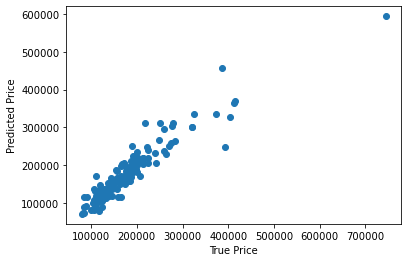

In [153]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')

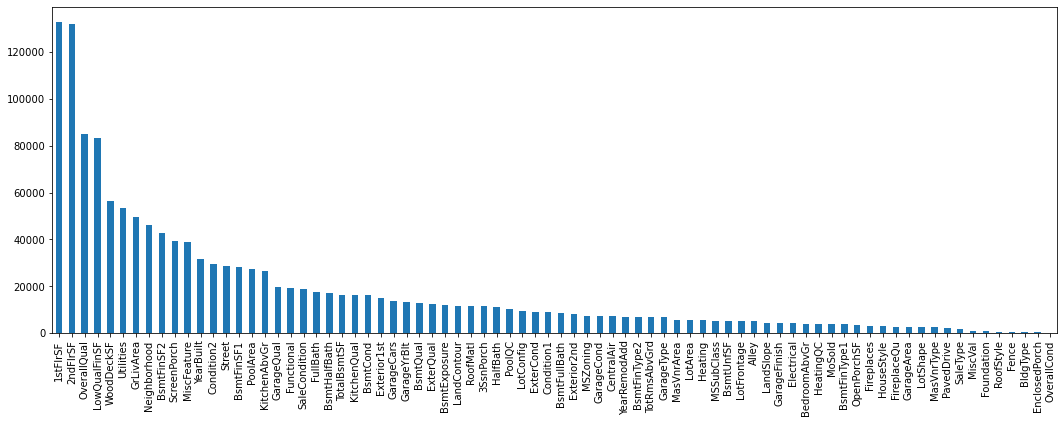

In [155]:
# let's explore the importance of the features
# the importance is given by the absolute value of the coefficient
# assigned by the Lasso

importance = pd.Series(np.abs(house_pipe.named_steps['lasso'].coef_))
importance.index = list(final_columns) #+['LotFrontage_na', 'MasVnrArea_na',  'GarageYrBlt_na']
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))